In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [108]:
df = pd.read_csv('1065final.csv')
print(df.shape)
df.head()

(2400, 14)


,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [109]:
df.isnull().sum()

id                            0
spacegroup                    0
number_of_total_atoms         0
percent_atom_al               0
percent_atom_ga               0
percent_atom_in               0
lattice_vector_1_ang          0
lattice_vector_2_ang          0
lattice_vector_3_ang          0
lattice_angle_alpha_degree    0
lattice_angle_beta_degree     0
lattice_angle_gamma_degree    0
formation_energy_ev_natom     0
bandgap_energy_ev             0
dtype: int64

## **Exploratory Data Analysis**

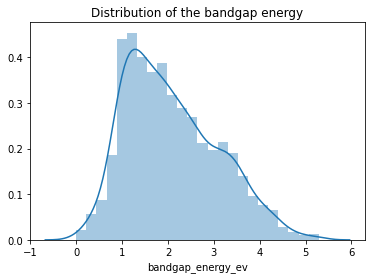

In [197]:
sns.distplot(df["bandgap_energy_ev"])
plt.title("Distribution of the bandgap energy")
plt.show()

In [198]:
df['spacegroup'].unique()

array([ 33, 194, 227, 167, 206,  12], dtype=int64)

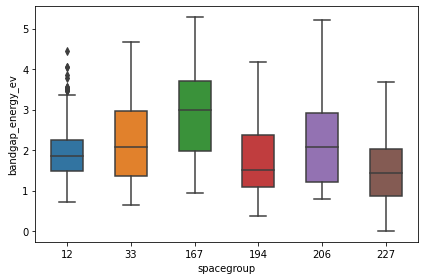

In [110]:
fig = sns.boxplot(x='spacegroup', y="bandgap_energy_ev", data=df, width=0.5)
plt.tight_layout()
plt.show()

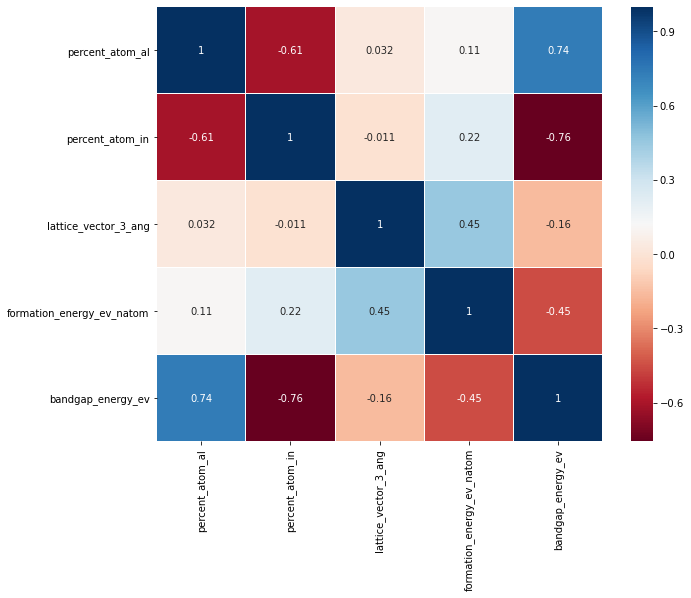

In [113]:
#Pearason corr
perasoncorr = df.corr()
corr_index = perasoncorr.index[abs(perasoncorr['bandgap_energy_ev'])>0.15]
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_index].corr(), cbar=True, cmap='RdBu', annot=True,linewidth=0.1)

## **Model Implementation**

In [114]:
X = df.drop(['id','formation_energy_ev_natom','bandgap_energy_ev'],axis=1)
Y = df.bandgap_energy_ev

In [115]:
# normalization 
X = (X-X.mean())/X.std()

In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

**1. Ridge regression**

In [133]:
# Fit a ridge regression model
from sklearn import linear_model
# tune hyperparameters by cross validation
for a in [0.5, 1, 1.5, 2, 2.5, 3]:
    ridge = linear_model.Ridge(alpha=a)
    print('----alpha=',a,'-----')
    score = cross_val_score(ridge, X_train, y_train, cv=5)
    print(np.mean(score))

----alpha= 0.5 -----
0.8034583037473204
----alpha= 1 -----
0.8034661087644437
----alpha= 1.5 -----
0.8034712428193382
----alpha= 2 -----
0.8034739220233286
----alpha= 2.5 -----
0.8034743446981031
----alpha= 3 -----
0.8034726920369654


In [136]:
# best ridge model: alpha=2.5
ridge = linear_model.Ridge(alpha=2.5).fit(X_train, y_train)
print('Evaluation for the ridge model in training set:')
y_train_est = ridge.predict(X_train)
MAE = np.abs(y_train_est - y_train).sum()/len(y_train_est)
print('Mean absolute error = ',MAE)

SST = ((y_train - y_train.mean())**2).sum()
SSR = ((y_train_est - y_train.mean())**2).sum()
R2 = SSR/SST
print('R-squared value = ', R2)

RMSE = np.sqrt(((y_train_est - y_train)**2).sum()/len(y_train_est))
print('Root mean squared error = ', RMSE)

Evaluation for the ridge model in training set:
Mean absolute error =  0.3187212903639097
R-squared value =  0.8036801774954558
Root mean squared error =  0.4430830905123834


**2. Neural Network**

In [144]:
# neural network
from sklearn.neural_network import MLPRegressor as MLP
for i in ['tanh','relu']:
    for j in [(5,5,5), (5,5), (10,10,10), (10,10)]:
        mlp = MLP(hidden_layer_sizes=j, activation=i, max_iter=500)
        print('activation=', i, ', hidden_layer_sizes=',j)
        score = cross_val_score(mlp, X_train, y_train, cv=5)
        print(np.mean(score))

activation= tanh , hidden_layer_sizes= (5, 5, 5)
0.9404510763687044
activation= tanh , hidden_layer_sizes= (5, 5)
0.9314302140732007
activation= tanh , hidden_layer_sizes= (10, 10, 10)
0.9436288737289861
activation= tanh , hidden_layer_sizes= (10, 10)
0.9428156120340262
activation= relu , hidden_layer_sizes= (5, 5, 5)
0.9333860536590143
activation= relu , hidden_layer_sizes= (5, 5)
0.9305525059036125
activation= relu , hidden_layer_sizes= (10, 10, 10)
0.9438401518734292
activation= relu , hidden_layer_sizes= (10, 10)
0.941651903267303


In [146]:
# best neural network model
mlp = MLP(hidden_layer_sizes=(10, 10, 10), activation='relu', max_iter=500).fit(X_train, y_train)
y_train_est = mlp.predict(X_train)
MAE = np.abs(y_train_est - y_train).sum()/len(y_train_est)
print('Mean absolute error = ',MAE)

SST = ((y_train - y_train.mean())**2).sum()
SSR = ((y_train_est - y_train.mean())**2).sum()
R2 = SSR/SST
print('R-squared value = ', R2)

RMSE = np.sqrt(((y_train_est - y_train)**2).sum()/len(y_train_est))
print('Root mean squared error = ', RMSE)


Mean absolute error =  0.1441876912648314
R-squared value =  0.9736602268412784
Root mean squared error =  0.21825324264144844


**3. Random Forest**

In [152]:
from sklearn.ensemble import RandomForestRegressor as RF
for i in range(30,211,30):
    rf = RF(n_estimators=i, oob_score=True)
    print('---n_estimators=', i,'---')
    score = cross_val_score(rf, X_train, y_train, cv=5)
    print(np.mean(score))


---n_estimators= 30 ---
0.9388191236982859
---n_estimators= 60 ---
0.9405533570891876
---n_estimators= 90 ---
0.9407144052515019
---n_estimators= 120 ---
0.9420944904015552
---n_estimators= 150 ---
0.9414766551694852
---n_estimators= 180 ---
0.941105740901666
---n_estimators= 210 ---
0.9419336053163221


In [155]:
# best random forest regressor
rf = RF(n_estimators=120, oob_score=True).fit(X_train, y_train)
y_train_est = rf.predict(X_train)
MAE = np.abs(y_train_est - y_train).sum()/len(y_train_est)
print('Mean absolute error = ',MAE)

SST = ((y_train - y_train.mean())**2).sum()
SSR = ((y_train_est - y_train.mean())**2).sum()
R2 = SSR/SST
print('R-squared value = ', R2)

RMSE = np.sqrt(((y_train_est - y_train)**2).sum()/len(y_train_est))
print('Root mean squared error = ', RMSE)

Mean absolute error =  0.07504615914499241
R-squared value =  0.9684664026136507
Root mean squared error =  0.12314162406436732


**4. XGBoost**

In [177]:
from xgboost.sklearn import XGBRegressor as XGB
for i in range(30,151,30):
    xgb = XGB(n_estimators=i, eta=0.1)
    print('---n_estimators=', i,'---')
    score = cross_val_score(xgb, X_train, y_train, cv=5)
    print(np.mean(score))

---n_estimators= 30 ---
0.9355798757672528
---n_estimators= 60 ---
0.9413811861381507
---n_estimators= 90 ---
0.9404302254174464
---n_estimators= 120 ---
0.9399131744232104
---n_estimators= 150 ---
0.9391951073039092


In [178]:
# best xgboost regressor
xgb = XGB(n_estimators=60, eta=0.1).fit(X_train, y_train)
y_train_est = xgb.predict(X_train)
MAE = np.abs(y_train_est - y_train).sum()/len(y_train_est)
print('Mean absolute error = ',MAE)

SST = ((y_train - y_train.mean())**2).sum()
SSR = ((y_train_est - y_train.mean())**2).sum()
R2 = SSR/SST
print('R-squared value = ', R2)

RMSE = np.sqrt(((y_train_est - y_train)**2).sum()/len(y_train_est))
print('Root mean squared error = ', RMSE)

Mean absolute error =  0.08492074984200298
R-squared value =  0.9631520943429971
Root mean squared error =  0.1294185082624314


## **Model Testing**

In [188]:
def test(model):
    y_test_est = model.predict(X_test)
    
    MAE = np.abs(y_test_est - y_test).sum()/len(y_test_est)
    print('Mean absolute error = ',MAE)

    SST = ((y_test - y_test.mean())**2).sum()
    SSR = ((y_test_est - y_test.mean())**2).sum()
    R2 = SSR/SST
    print('R-squared value = ', R2)

    RMSE = np.sqrt(((y_test_est - y_test)**2).sum()/len(y_test_est))
    print('Root mean squared error = ', RMSE)
    
    plt.scatter(y_test_est,y_test)
    plt.xlabel('test predictions')
    plt.ylabel('true values')
    plt.title('test predictions vs. true values')
    plt.show()

Mean absolute error =  0.3307874510840777
R-squared value =  0.8253933085754238
Root mean squared error =  0.4725218790959156


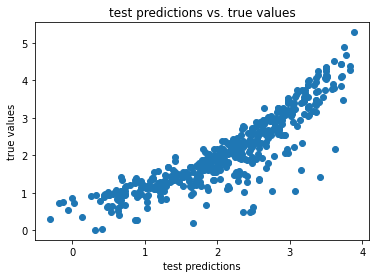

In [189]:
test(ridge)

Mean absolute error =  0.15255850305281513
R-squared value =  0.9602982141599525
Root mean squared error =  0.23657162212733693


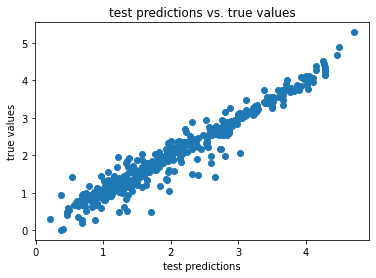

In [190]:
test(mlp)

Mean absolute error =  0.1422895814579397
R-squared value =  0.9331620496007119
Root mean squared error =  0.2321991582792261


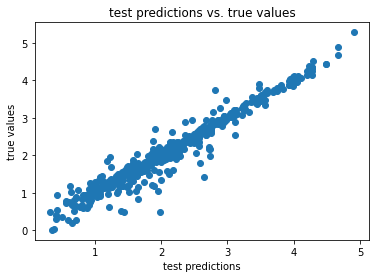

In [191]:
test(rf)

Mean absolute error =  0.13697327822307745
R-squared value =  0.9282638935702434
Root mean squared error =  0.2236476231512626


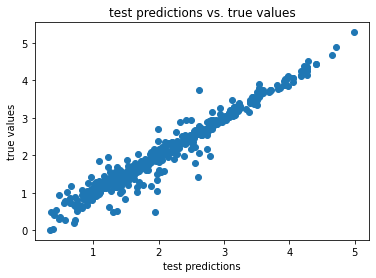

In [192]:
test(xgb)